
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [27]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import pandas as pd

import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all ConvergenceWarning warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


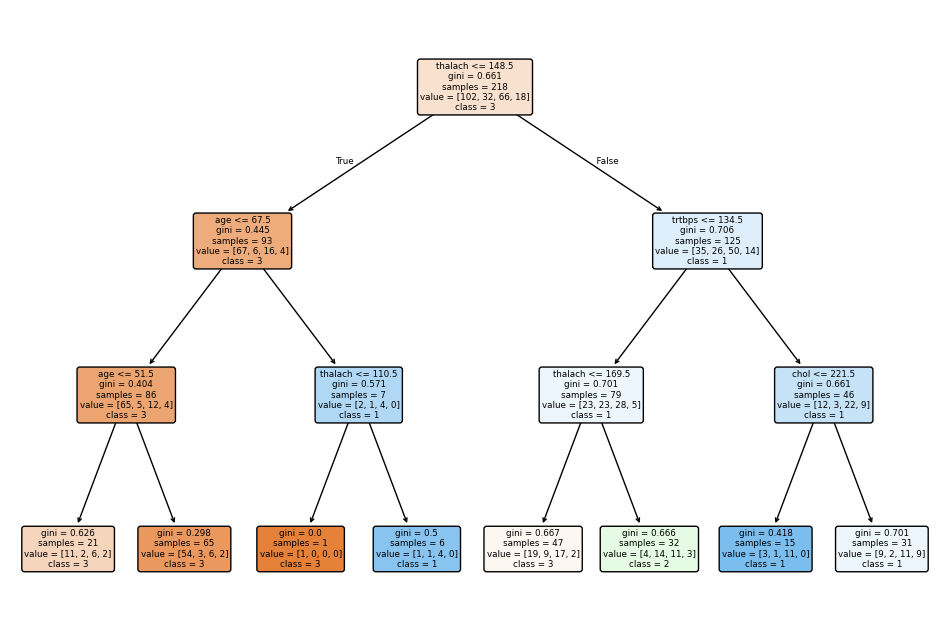

In [5]:
# Prepare the data
X = ha.drop(columns=['output', 'cp'])
y = ha['cp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=3) # Limiting depth for better visualization
dt.fit(X_train, y_train)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, class_names=y.unique().astype(str), filled=True, rounded=True)
plt.show()

# Interpretation of the first splits (example):
# The first split is based on the 'thalach' feature.  If 'thalach' <= 133.5,
# then the model predicts that the chest pain type is more likely to be 0 or 2, otherwise
# it moves down the tree to consider another feature.
# The second split further divides those data points into more specific groups based on 'age'.
# The exact interpretation will depend on the generated plot.



KNN Accuracy (mean): 0.451, Std: 0.070
Decision Tree Accuracy (mean): 1.000, Std: 0.000


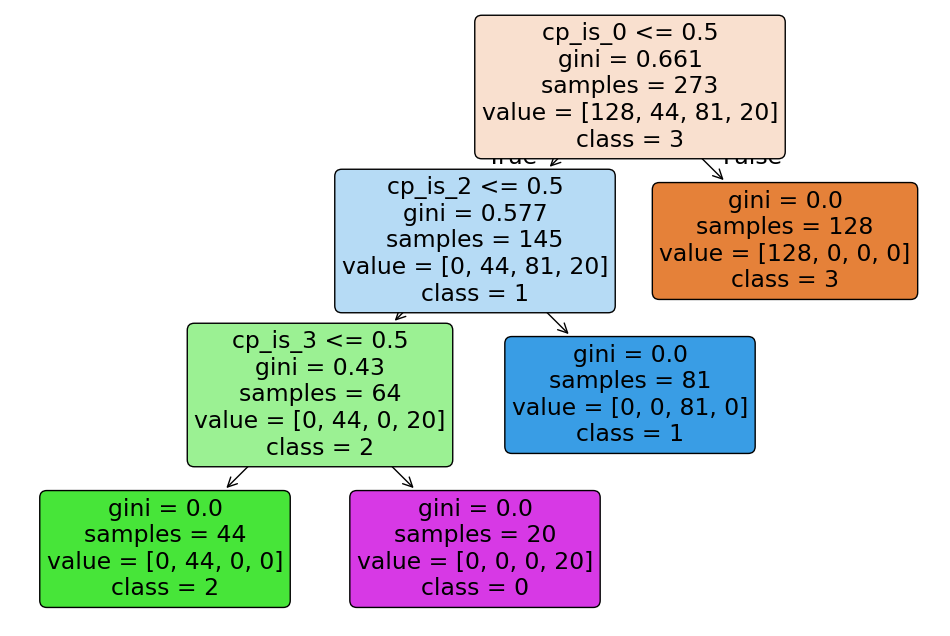

LDA Accuracy (mean): 0.465, Std: 0.088


In [35]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# Prepare the data
X = ha.drop(columns=['output', 'cp'])
y = ha['cp']

# KNN
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print(f"KNN Accuracy (mean): {knn_scores.mean():.3f}, Std: {knn_scores.std():.3f}")

# Decision Tree
dt = DecisionTreeClassifier(max_depth=3)  # Limiting depth for better visualization
dt_scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
print(f"Decision Tree Accuracy (mean): {dt_scores.mean():.3f}, Std: {dt_scores.std():.3f}")

# Train the decision tree on the entire dataset for visualization
dt.fit(X, y)
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, class_names=y.unique().astype(str), filled=True, rounded=True)
plt.show()

# LDA
lda = LinearDiscriminantAnalysis()
lda_scores = cross_val_score(lda, X, y, cv=5, scoring='accuracy')
print(f"LDA Accuracy (mean): {lda_scores.mean():.3f}, Std: {lda_scores.std():.3f}")


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [37]:
# Create new target variables for one-vs-rest (OvR) classification
for i in range(4):
    ha[f'cp_is_{i}'] = (ha['cp'] == i).astype(int)

results = {}

for i in range(4):
    # Prepare the data
    X = ha.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
    y = ha[f'cp_is_{i}']

    # Fit Logistic Regression with cross-validation
    logreg = LogisticRegression()
    y_pred = cross_val_predict(logreg, X, y, cv=5)  # Generate cross-validated predictions

    # Classification Report
    print(f"Classification Report for cp_is_{i}:\n{classification_report(y, y_pred)}")

    # Calculate F1 Score
    f1 = f1_score(y, y_pred)
    results[i] = f1
    print(f"F1 Score for cp_is_{i}: {f1}\n")

# Identify the best-performing category
best_category = max(results, key=results.get)
print(f"\nThe OvR approach was best at distinguishing cp category {best_category} with an F1 score of {results[best_category]:.3f}.")


Classification Report for cp_is_0:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       145
           1       0.64      0.56      0.60       128

    accuracy                           0.64       273
   macro avg       0.64      0.64      0.64       273
weighted avg       0.64      0.64      0.64       273

F1 Score for cp_is_0: 0.5975103734439834

Classification Report for cp_is_1:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       229
           1       0.00      0.00      0.00        44

    accuracy                           0.83       273
   macro avg       0.42      0.50      0.45       273
weighted avg       0.70      0.83      0.76       273

F1 Score for cp_is_1: 0.0

Classification Report for cp_is_2:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       192
           1       0.17      0.05      0.08        81

    accu

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [39]:
# Function to perform OvO logistic regression with cross-validation and return ROC-AUC
def ovo_logreg_cv(df, cp1, cp2, cv=5):
    # Subset the data for the two classes being compared
    subset = df[df['cp'].isin([cp1, cp2])]
    X = subset.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
    y = (subset['cp'] == cp2).astype(int)  # Binary target: 1 if cp == cp2, 0 otherwise

    # Logistic Regression with cross-validation
    logreg = LogisticRegression()
    y_pred = cross_val_predict(logreg, X, y, cv=5)

    # Compute ROC-AUC
    roc_auc = roc_auc_score(y, y_pred)
    return roc_auc

# Compare category 0 to 1, 0 to 2, and 0 to 3 using cross-validation
roc_auc_01 = ovo_logreg_cv(ha, 0, 1, cv=5)
roc_auc_02 = ovo_logreg_cv(ha, 0, 2, cv=5)
roc_auc_03 = ovo_logreg_cv(ha, 0, 3, cv=5)

print(f"ROC-AUC for cp 0 vs 1: {roc_auc_01:.3f}")
print(f"ROC-AUC for cp 0 vs 2: {roc_auc_02:.3f}")
print(f"ROC-AUC for cp 0 vs 3: {roc_auc_03:.3f}")

# Determine the best-performing pair
results_ovo = {
    "0 vs 1": roc_auc_01,
    "0 vs 2": roc_auc_02,
    "0 vs 3": roc_auc_03
}
best_pair_ovo = max(results_ovo, key=results_ovo.get)
print(f"\nThe OvO approach was best at distinguishing {best_pair_ovo} with an ROC-AUC of {results_ovo[best_pair_ovo]:.3f}.")


ROC-AUC for cp 0 vs 1: 0.624
ROC-AUC for cp 0 vs 2: 0.572
ROC-AUC for cp 0 vs 3: 0.477

The OvO approach was best at distinguishing 0 vs 1 with an ROC-AUC of 0.624.
